# UD-MIS via QAOA

**Software**: PennyLane <br>
**Hardware**: (1) AWS Braket Simulator-SV1, (2) IonQ

In [18]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa

import networkx as nx
import matplotlib.pyplot as plt

Initial point seed

In [3]:
np.random.seed(26)

Problem definition

In [4]:
n_wires = 4
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]

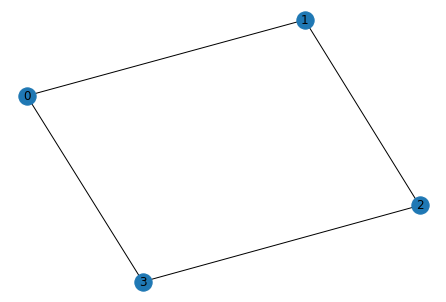

In [17]:
nx_graph = nx.Graph(graph)

nx.draw(nx_graph, with_labels=True)
plt.show()

**Cost and Mixer**

In [21]:
cost_h, mixer_h = qaoa.max_independent_set(nx_graph, constrained=True)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (1) [Z0]
+ (1) [Z1]
+ (1) [Z3]
+ (1) [Z2]
Mixer Hamiltonian   (0.25) [X0]
+ (0.25) [X1]
+ (0.25) [X3]
+ (0.25) [X2]
+ (0.25) [X0 Z3]
+ (0.25) [X0 Z1]
+ (0.25) [X1 Z2]
+ (0.25) [X1 Z0]
+ (0.25) [X3 Z2]
+ (0.25) [X3 Z0]
+ (0.25) [X2 Z3]
+ (0.25) [X2 Z1]
+ (0.25) [X0 Z1 Z3]
+ (0.25) [X1 Z0 Z2]
+ (0.25) [X3 Z0 Z2]
+ (0.25) [X2 Z1 Z3]


**QAOA construction**

In [22]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [23]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [25]:
dev = qml.device("default.qubit", wires=wires)
cost_function = qml.ExpvalCost(circuit, cost_h, dev)

**SGD Optimization**

In [26]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = [[0.5, 0.5], [0.5, 0.5]]

In [27]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.8920698839400695, 0.3719046134789388], [0.8166937045106254, 1.2009856407425092]]


In [28]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

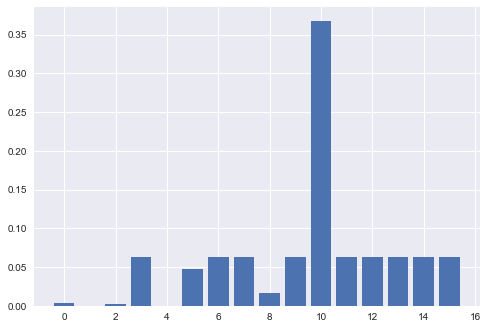

In [29]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

**SGD vs ADAM (vs Adagrad)**

In [42]:
steps = 200
init_params = [[0.5, 0.5], [0.5, 0.5]]

In [34]:
gd_cost = []
opt = qml.GradientDescentOptimizer(0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(cost_function, theta)
    gd_cost.append(cost_function(theta))

In [36]:
adam_cost = []
opt = qml.AdamOptimizer(stepsize=0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(cost_function, theta)
    adam_cost.append(cost_function(theta))

In [43]:
adagrad_cost = []
opt = qml.AdagradOptimizer(stepsize=0.01)

theta = init_params
for _ in range(steps):
    theta = opt.step(cost_function, theta)
    adagrad_cost.append(cost_function(theta))

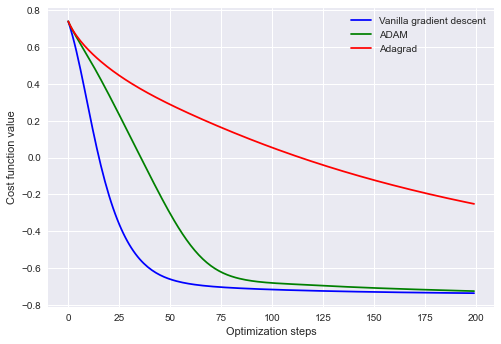

In [44]:
plt.style.use("seaborn")
plt.plot(gd_cost, "b", label="Vanilla gradient descent")
plt.plot(adam_cost, "g", label="ADAM")
plt.plot(adagrad_cost, "r", label="Adagrad")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()